In [2]:
## conda install -c conda-forge python-engineio=2.2.0
## conda env create -f environment.yml

# packages
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import cv2
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Flatten,Dense,Lambda,Dropout
from tensorflow.keras.optimizers import Adam
import h5py

from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint

## Step 1: Initialize Data

In [3]:
# functions

# TO REMOVE FILE PATH AND GET ONLY FILE NAME
def getName(filePath):
    return filePath.split('\\')[-1]
 
                          
# To Import the data from the simulation then remove the path of the Center
def importDataInfo(path):
    columns = ['Center', 'Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed']
    data = pd.read_csv(os.path.join(path, 'driving_log.csv'), names = columns)
    
    
    
    
    #### REMOVE FILE PATH AND GET ONLY FILE NAME
    #print(getName(data['center'][0]))
    #data['Center']=data['Center'].apply(getName)
    #print(data.head())
    print('Total Images Imported',data.shape[0])
    return data

In [4]:
path = 'folder_1'
data = importDataInfo(path)

Total Images Imported 412


In [5]:
data.head()

,Center,Left,Right,Steering,Throttle,Brake,Speed
0,1,0.0,0.0,-0.25,0.0,0.0,0.0
1,2,NaN,NaN,0.10,NaN,NaN,NaN
2,3,NaN,NaN,0.30,NaN,NaN,NaN
3,4,NaN,NaN,0.30,NaN,NaN,NaN
4,5,NaN,NaN,0.05,NaN,NaN,NaN


## Step 2: Visualize and Balance Data

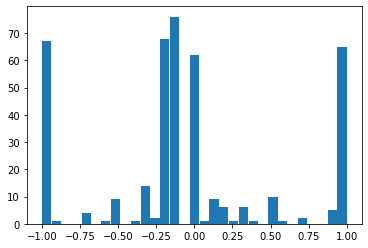

In [6]:
nBin = 31
hist, bins = np.histogram(data['Steering'], nBin)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.06)
plt.show()

In [7]:
# functions

def balanceData(data, samplesPerBin ,display=True):
    nBin = 31
    hist, bins = np.histogram(data['Steering'], nBin)
    center = (bins[:-1] + bins[1:]) * 0.5

    if display:
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()
        
    
    removeindexList = []
    for j in range(nBin):
        binDataList = []
        for i in range(len(data['Steering'])):
            if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j + 1]:
                binDataList.append(i)
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removeindexList.extend(binDataList)
 
    print('Removed Images:', len(removeindexList))
    data.drop(data.index[removeindexList], inplace=True)
    print('Remaining Images:', len(data))
    
    
    if display:
        hist, _ = np.histogram(data['Steering'], (nBin))
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()


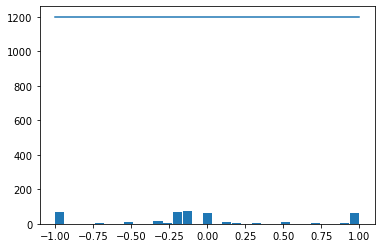

Removed Images: 0
Remaining Images: 412


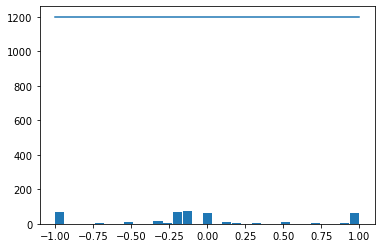

In [8]:
balanceData(data , 1200)
#data = balanceData(data, 500 ,display=False)

## Step 3: Prepare for processing

In [9]:
## getting (imagesPath, steerings)

def loadData(path, data):
    imagesPath = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        n = i+1
        imagesPath.append(f'{path}/IMG/{"img-%s.jpg" % n}')
        steering.append(float(indexed_data[3]))
    imagesPath = np.asarray(imagesPath)
    steering = np.asarray(steering)
    return imagesPath, steering

In [10]:
imagesPath, steerings = loadData(path, data)

print(imagesPath[0])
print(steerings[0])

folder_1/IMG/img-1.jpg
-0.25


## Step 4: Split for Training and Validation

In [11]:
xTrain, xVal, yTrain, yVal = train_test_split(imagesPath, steerings, test_size=0.2,random_state=10)

print('Total Training Images: ',len(xTrain))
print('Total Validation Images: ',len(xVal))

Total Training Images:  329
Total Validation Images:  83


## Step 5: Data Augmentation

In [12]:
# functions

def augmentImage(imgPath,steering):
    img =  cv2.imread(imgPath)
    
    # Pan
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = pan.augment_image(img)
        
    # Zoom
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)
        
    # Brightness
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.2, 1.2))
        img = brightness.augment_image(img)
        
    # Flip
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering = -steering
    return img, steering

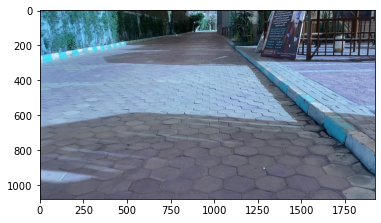

In [13]:
imgPath = 'folder_1/IMG/img-1.jpg'
img_orig =  cv2.imread(imgPath)
plt.imshow(img_orig)
plt.show()

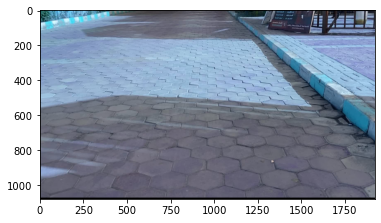

In [14]:
img_aug, steering = augmentImage(imgPath, 0.5)

plt.imshow(img_aug)
plt.show()

## Step 6: Data Preprocessing

In [15]:
def mask2(image):
    original = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower = np.array([22, 93, 0], dtype="uint8")
    upper = np.array([45, 255, 255], dtype="uint8")
    mask = cv2.inRange(image, lower, upper)

    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(original, (x, y), (x + w, y + h), (36,255,12), 2)

    #cv2.imshow('mask', mask)
#     cv2.imshow('original', original)
#     cv2.waitKey()
    return original


# img = cv2.imread(imgPath)
# img = cv2.resize(img_orig, (240, 120))
# img = np.asarray(img)
# plt.imshow(mask2(img))
# plt.show()

In [16]:
# functions

def preProcess(img ,display=False):
    
    if display:
        print("Original:")
        plt.imshow(img)
        plt.show()
    
    
    img = cv2.resize(img, (240, 120))
    img = np.asarray(img)
        
    ## Masking
    img = mask2(img)
    if display:
        print("Mask:")
        plt.imshow(img)
        plt.show()

    ## Cropping
    img = img[60:135,:,:]
    
    if display:
        print("1- Crop:")
        plt.imshow(img)
        plt.show()
    
    
    
    ## YUV Colorspace
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
    if display:
        print("2- YUV Colorspace:")
        plt.imshow(img)
        plt.show()    
    
    
    
    ## Blur
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    
    if display:
        print("3- Blur:")
        plt.imshow(img)
        plt.show()     
    
    
    
    ## Resize
    img = cv2.resize(img, (200, 66))
    
    if display:
        print("4- Resize:")
        plt.imshow(img)
        plt.show() 
        
        
        
    ## Rescale
    img = img/255
    
    
    if display:
        print("5- Rescale:")
        plt.imshow(img)
        plt.show() 
        
        
    return img



Original:


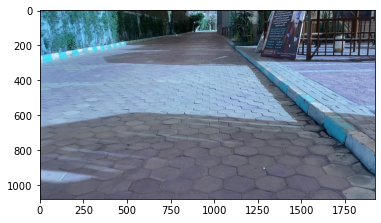

Mask:


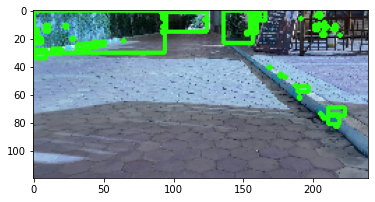

1- Crop:


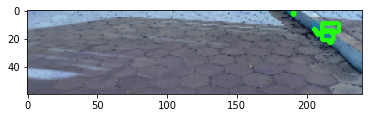

2- YUV Colorspace:


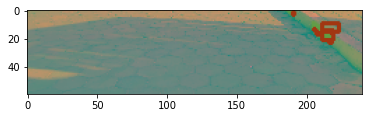

3- Blur:


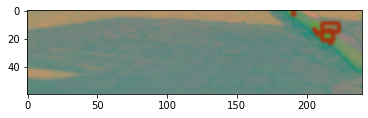

4- Resize:


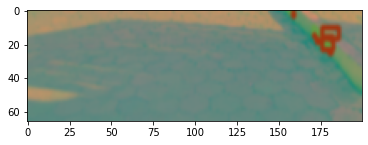

5- Rescale:


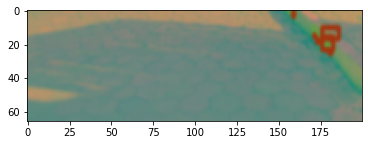

In [17]:

img = preProcess(img_orig ,display=True)


## Step 7: Batch Generator

In [18]:
# functions

def batchGen(imagesPath, steeringList, batchSize, trainFlag):
    while True:
        imgBatch = []
        steeringBatch = []

        for i in range(batchSize):
            # choose random image
            index = random.randint(0, len(imagesPath) - 1)
            
            
            
            # Augment Images for training set only
            if trainFlag:
                img, steering = augmentImage(imagesPath[index], steeringList[index])
            else:
                img = cv2.imread(imagesPath[index])
                steering = steeringList[index]
            
            # PreProcess Images
            img = preProcess(img)
            
            imgBatch.append(img)
            steeringBatch.append(steering)
            
        yield (np.asarray(imgBatch),np.asarray(steeringBatch))

## Step 8: Creating the Model


In [19]:
# to remove wornings
print('Setting UP')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Setting UP


In [28]:
# Self Driving Simulation using CNN NVIDIA's MODEL Tensorflow (2020)


def createModel():
    model = Sequential()
    model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
 
    model.add(Flatten())
    model.add(Dense(100, activation = 'elu'))
    model.add(Dense(50, activation = 'elu'))
    model.add(Dense(10, activation = 'elu'))
    model.add(Dense(1))
 
    model.compile(Adam(lr=0.0001),loss='mse')
    return model

In [29]:
model = createModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

C:\Users\Andrew\anaconda3\envs\PyQt5\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [30]:
from datetime import datetime, date , timedelta

def time(beginning = 0):
    if beginning == 0:
        beginning = datetime.now()
    now = datetime.now()
    
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    
    duration_time = now - beginning
    
    print("Duration Time =", duration_time)
    return now

x = time()

Current Time = 01:44:23
Duration Time = 0:00:00


## Step 9: Train the Model


In [32]:

checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')



history = model.fit(batchGen(xTrain,yTrain,100,True) , steps_per_epoch= 300 , epochs= 30 , 
                    validation_data= batchGen(xVal , yVal ,100 , False)
                   , validation_steps= 200)




# history = model.fit(batchGen(xTrain, yTrain, 100, 1),
#                                   steps_per_epoch=100,
#                                   epochs=10,
#                                   validation_data=batchGen(xVal, yVal, 50, 0),
#                                   validation_steps=50)


x = time(x)

Epoch 1/30
300/300 [==============================] - 2470s 8s/step - loss: 0.2758 - val_loss: 0.3716
Epoch 2/30
300/300 [==============================] - 2399s 8s/step - loss: 0.2521 - val_loss: 0.3574
Epoch 3/30
300/300 [==============================] - 2408s 8s/step - loss: 0.2414 - val_loss: 0.3330
Epoch 4/30
300/300 [==============================] - 2390s 8s/step - loss: 0.2173 - val_loss: 0.3169
Epoch 5/30
300/300 [==============================] - 2390s 8s/step - loss: 0.1971 - val_loss: 0.2955
Epoch 6/30
300/300 [==============================] - 2383s 8s/step - loss: 0.1759 - val_loss: 0.2750
Epoch 7/30
300/300 [==============================] - 2394s 8s/step - loss: 0.1616 - val_loss: 0.2323
Epoch 8/30
300/300 [==============================] - 2386s 8s/step - loss: 0.1469 - val_loss: 0.2207
Epoch 9/30
300/300 [==============================] - 2384s 8s/step - loss: 0.1313 - val_loss: 0.2067
Epoch 10/30
300/300 [==============================] - 2372s 8s/step - loss: 0.119

## Step 10: Save and Plot the Model


In [33]:
import h5py
model.save('model_v3.h5')
print('Model Saved')

Model Saved


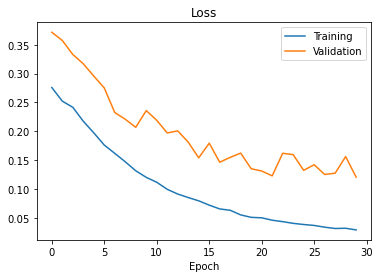

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

#plt.ylim([0,1])
plt.legend(['Training','Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

In [21]:
from datetime import datetime, date , timedelta

def time(beginning = 0):
    if beginning == 0:
        beginning = datetime.now()
    now = datetime.now()
    
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    
    duration_time = now - beginning
    
    print("Duration Time =", duration_time)
    return now

x = time()
    

Current Time = 02:46:39
Duration Time = 0:00:00


In [23]:
from tensorflow.keras import models
model = models.load_model('model_v3.h5')

history2 = model.fit(batchGen(xTrain,yTrain,100,True) , steps_per_epoch= 400 , epochs= 10 , 
                    validation_data= batchGen(xVal , yVal ,100 , False)
                   , validation_steps= 200)
x = time(x)

Epoch 1/10
400/400 [==============================] - 3171s 8s/step - loss: 0.0282 - val_loss: 0.1265
Epoch 2/10
400/400 [==============================] - 3071s 8s/step - loss: 0.0266 - val_loss: 0.1181
Epoch 3/10
400/400 [==============================] - 3044s 8s/step - loss: 0.0261 - val_loss: 0.1133
Epoch 4/10
400/400 [==============================] - 3038s 8s/step - loss: 0.0245 - val_loss: 0.1054
Epoch 5/10
400/400 [==============================] - 3035s 8s/step - loss: 0.0211 - val_loss: 0.1190
Epoch 6/10
400/400 [==============================] - 3031s 8s/step - loss: 0.0214 - val_loss: 0.1160
Epoch 7/10
400/400 [==============================] - 3017s 8s/step - loss: 0.0204 - val_loss: 0.1162
Epoch 8/10
400/400 [==============================] - 3014s 8s/step - loss: 0.0199 - val_loss: 0.1174
Epoch 9/10
400/400 [==============================] - 3120s 8s/step - loss: 0.0185 - val_loss: 0.1187
Epoch 10/10
400/400 [==============================] - 3094s 8s/step - loss: 0.017

In [24]:
import h5py
model.save('model_v4.h5')
print('Model Saved')
x = time(x)

Model Saved
Current Time = 11:21:48
Duration Time = 0:00:00.451816


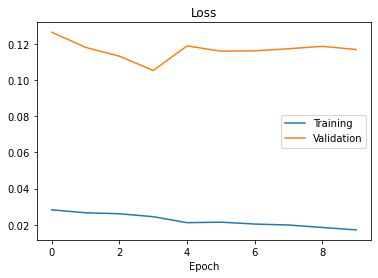

In [25]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

#plt.ylim([0,1])
plt.legend(['Training','Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

In [26]:
history2 = model.fit(batchGen(xTrain,yTrain,100,True) , steps_per_epoch= 400 , epochs= 10 , 
                    validation_data= batchGen(xVal , yVal ,100 , False)
                   , validation_steps= 200)
x = time(x)

Epoch 1/10
400/400 [==============================] - 3039s 8s/step - loss: 0.0169 - val_loss: 0.1049
Epoch 2/10
400/400 [==============================] - 3006s 8s/step - loss: 0.0160 - val_loss: 0.1127
Epoch 3/10
209/400 [==============>...............] - ETA: 19:23 - loss: 0.0168

KeyboardInterrupt: 

In [ ]:
import h5py
model.save('model_v5.h5')
print('Model Saved')
x = time(x)

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

#plt.ylim([0,1])
plt.legend(['Training','Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
history2 = model.fit(batchGen(xTrain,yTrain,100,True) , steps_per_epoch= 400 , epochs= 10 , 
                    validation_data= batchGen(xVal , yVal ,100 , False)
                   , validation_steps= 200)
x = time(x)

In [ ]:
import h5py
model.save('model_v6.h5')
print('Model Saved')
x = time(x)

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

#plt.ylim([0,1])
plt.legend(['Training','Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()